In [202]:
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [203]:

HIGH_INCOME_THRESHOLD = 70000  # Threshold to categorize high vs low income
CITY_MEDIAN_INCOME = 50000
AFFORDABILITY_RATIO = 0.30  # Max 30% of income on rent


class Household:
    def __init__(self, id, income, amenity_pref, move_tolerance, stability, cost_sensitivity):
        self.id = id
        self.income = income
        self.budget = AFFORDABILITY_RATIO * income
        self.amenity_pref = amenity_pref # weight for neighborhood amenity in utility 
        self.move_tolerance = move_tolerance
        self.stability = stability           # probability of considering a move
        self.current_unit = None             # reference to current housing unit or location
        self.time_since_move = 0 
        self.cost_sensitivity = cost_sensitivity  # weight for rent cost in utility
        self.current_unit = None
        
    def move_to(self, unit: HousingUnit):    #Move to a new unit
        unit.vacant = False
        unit.tenant = self
        self.current_unit = unit
        
    def decide_and_move(self, available_units: list[HousingUnit]):
        if random.random() > (1 - self.stability) or self.time_since_move < 1:     # Only consider moving if stability trigger allows and not in cooldown
            self.time_since_move += 1    # Stability condition not met or still in cooldown
            return

        if self.current_unit is None:
            affordable = [u for u in housing_options 
                         if u.vacant and u.rent <= self.rent_budget]
            if affordable:
                best = max(affordable, 
                          key=lambda u: self.calculate_utility(u.neighborhood.amenity, u.rent))
                self.move_to_unit(best)
            return
        # Calculate current utility with normalized values
        curr_amenity = self.current_unit.neighborhood.amenity
        curr_rent = self.current_unit.rent
        current_utility = self.calculate_utility(curr_amenity, curr_rent)

        best_unit = None
        best_utility = current_utility

        for unit in available_units:
            if unit is self.current_unit or not unit.vacant:
                continue
            if unit.rent > self.budget:
                continue
            new_utility = self.calculate_utility(unit.neighborhood.amenity, unit.rent)
            
            # Only move if significantly better (moving cost = 0.2 utility points)
            if new_utility - 0.2 > best_utility:
                best_utility = new_utility
                best_unit = unit

        if best_unit:
            self.current_unit.vacant = True
            self.current_unit.tenant = None
            self.move_to(best_unit)
            
    def calculate_utility(self, amenity, rent): #Calculate utility with normalized amenity and rent
        normalized_amenity = amenity / 10  # assuming 0-10 scale
        normalized_rent = rent / self.budget  # rent as fraction of budget
        utility = self.amenity_pref * normalized_amenity - self.cost_sensitivity * normalized_rent
        return utility

        
    

In [204]:
class HousingUnit:
    def __init__(self, id, neighborhood: 'Neighborhood', rent):
        self.id = id
        self.neighborhood = neighborhood
        self.rent = rent
        self.vacant = True
        self.tenant = None


In [205]:
class Landlord:
    def __init__(self, id, unit: HousingUnit):
        self.id = id
        self.unit = unit
        self.unit.landlord = self
        self.vacancy_count = 0
        self.occupied_count = 0
        self.base_rent = unit.rent  #remember initial rent
        self.price_aggressiveness = random.uniform(0.5, 1.5)  #how reactive to the market
        
    def adjust_rent(self, demand_level, neighborhood_avg_rent):
        if self.unit.vacant:
            self.vacancy_count += 1
            self.occupied_count
            
            if self.vacancy_count >= 3:
                reduction = 0.06 * self.price_aggressiveness   #about 3 to 9 percent reduction
                self.unit.rent = self.unit.rent * (1- reduction)
                self.unit.rent = max(self.unit.rent, self.base_rent * 0.75)  # Don't go below 75% of base rent 
        else:
            self.occupied_count += 1
            self.vacancy_count = 0
            
            if demand_level == "high" and self.occupied_count >= 3:
                if self.unit.rent < avg_rent * 0.95:
                    increase = 0.04 * self.price_aggressiveness   # about 2-6 percent increase
                    self.unit.rent *= (1+ increase)
            elif self.occupied_count >= 4:   #annual increase
                self.unit.rent *= 1.015
        self.unit.rent = min(self.unit.rent, self.base_rent * 2)    #Cap rent growth at 200% of base rent

            
    
 


In [206]:
class Neighborhood:
    def __init__(self, name, initial_amenity):
        self.name = name
        self.amenity = initial_amenity
        self.units: List[HousingUnit] = []
        self.high_income_count = 0
        self.low_income_count = 0
        self.avg_rent = 0  # Track average rent in neighborhood

    
    def update_composition(self):       #Count resident income levels and calculate average rent
        self.high_income_count = 0
        self.low_income_count = 0
        total_rent = 0
        count = 0
        
        for unit in self.units:
            if not unit.vacant and unit.tenant:
                if unit.tenant.income > HIGH_INCOME_THRESHOLD:
                    self.high_income_count += 1
                else:
                    self.low_income_count += 1
                total_rent += unit.rent
                count += 1
        
        self.avg_rent = total_rent / count if count > 0 else 0

    
    def update_amenity(self):     #Adjust amenity based on residents
        total = self.high_income_count + self.low_income_count
        if total == 0:
            return
        
        high_proportion = self.high_income_count / total
        
        # More high-income residents → better amenities
        if high_proportion > 0.6:
            self.amenity += 0.1
        # Mostly low-income → amenity decays
        elif high_proportion < 0.3:
            self.amenity -= 0.05
        
        # Keep amenity in valid range
        self.amenity = max(0, min(self.amenity, 10))

In [207]:
class HousingSimulation:
    
    def __init__(self, n_households: int = 100, n_neighborhoods: int = 3,
                 units_per_neighborhood: int = 40, n_steps: int = 50):
        self.n_households = n_households
        self.n_neighborhoods = n_neighborhoods
        self.units_per_neighborhood = units_per_neighborhood
        self.n_steps = n_steps
        
        self.households: List[Household] = []
        self.landlords: List[Landlord] = []
        self.neighborhoods: List[Neighborhood] = []
        self.units: List[HousingUnit] = []
        
        # To track the data for model
        self.avg_rent_history = []
        self.amenity_history = {i: [] for i in range(n_neighborhoods)}
        self.segregation_history = []
        
        self._initialize()
    
    def _initialize(self):
        # Create neighborhoods
        for i in range(self.n_neighborhoods):
            amenity = random.uniform(4, 7)
            nbhd = Neighborhood(f"Area_{i+1}", amenity)
            self.neighborhoods.append(nbhd)
        
        # Create units and landlords
        unit_id = 0
        for nbhd in self.neighborhoods:
            for _ in range(self.units_per_neighborhood):
                rent = random.uniform(800, 1800)
                unit = HousingUnit(unit_id, nbhd, rent)
                nbhd.units.append(unit)
                self.units.append(unit)
                
                landlord = Landlord(unit_id, unit)
                self.landlords.append(landlord)
                unit_id += 1
        
        # Create households with all required parameters
        for i in range(self.n_households):
            income = random.gauss(50000, 20000)
            income = max(25000, min(income, 120000))
            
            hh = Household(
                id=i,
                income=income,
                amenity_pref=random.uniform(1.0, 3.0),
                move_tolerance=random.uniform(0.2, 0.8),
                stability=random.uniform(0.8, 0.95),
                cost_sensitivity=random.uniform(1.0, 2.5)
            )
            self.households.append(hh)
        
        # Initial placement
        available = self.units.copy()
        random.shuffle(available)
        for hh in self.households:
            affordable = [u for u in available if u.rent <= hh.budget]
            if affordable:
                unit = affordable[0]
                hh.move_to(unit)
                available.remove(unit)
    
    def run(self):
        """Run simulation"""
        print(f"Running simulation for {self.n_steps} steps...")
        
        for t in range(self.n_steps):
            if t % 10 == 0:
                print(f"  Step {t}/{self.n_steps}")
            
            # 1. Households consider moving
            for hh in self.households:
                hh.decide_and_move(self.units)
            
            # 2. Landlords adjust rents
            for landlord in self.landlords:
                nbhd = landlord.unit.neighborhood
                demand = "high" if nbhd.high_income_count > nbhd.low_income_count else "low"
                landlord.adjust_rent(demand, nbhd.avg_rent)
            
            # 3. Neighborhoods update
            for nbhd in self.neighborhoods:
                nbhd.update_composition()
                nbhd.update_amenity()
            
            # 4. Collect data
            self._collect_data()
        
        print("Simulation complete!")
    
    def _collect_data(self):
        # Average rent
        occupied_rents = [l.unit.rent for l in self.landlords if not l.unit.vacant]
        avg_rent = np.mean(occupied_rents) if occupied_rents else 0
        self.avg_rent_history.append(avg_rent)
        
        # Amenity by neighborhood
        for i, nbhd in enumerate(self.neighborhoods):
            self.amenity_history[i].append(nbhd.amenity)
        
        # Segregation (variance of neighborhood average incomes)
        nbhd_incomes = []
        for nbhd in self.neighborhoods:
            incomes = [u.tenant.income for u in nbhd.units 
                      if not u.vacant and u.tenant]
            if incomes:
                nbhd_incomes.append(np.mean(incomes))
        
        if nbhd_incomes:
            segregation = np.var(nbhd_incomes)
        else:
            segregation = 0
        self.segregation_history.append(segregation)
    
    def visualize(self):
        """Create essential plots only"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Plot 1: Rent trend
        axes[0].plot(self.avg_rent_history, linewidth=2.5, color='#2E86AB')
        axes[0].set_title("Average Rent Over Time", fontsize=12, fontweight='bold')
        axes[0].set_xlabel("Time Step")
        axes[0].set_ylabel("Average Rent ($)")
        axes[0].grid(alpha=0.3)
        
        # Plot 2: Amenity evolution
        colors = ['#F18F01', '#06A77D', '#A23B72']
        for i, (nbhd_id, series) in enumerate(self.amenity_history.items()):
            axes[1].plot(series, linewidth=2.5, label=f"Area {nbhd_id+1}", 
                        color=colors[i % len(colors)], alpha=0.8)
        axes[1].set_title("Neighborhood Amenity Evolution", fontsize=12, fontweight='bold')
        axes[1].set_xlabel("Time Step")
        axes[1].set_ylabel("Amenity Score")
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        
        # Plot 3: Segregation
        axes[2].plot(self.segregation_history, linewidth=2.5, color='#A23B72')
        axes[2].set_title("Income Segregation", fontsize=12, fontweight='bold')
        axes[2].set_xlabel("Time Step")
        axes[2].set_ylabel("Variance of Neighborhood Incomes")
        axes[2].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        self._print_summary()
    
    def _print_summary(self):
        """Print summary statistics"""
        print("\n" + "="*50)
        print("SIMULATION SUMMARY")
        print("="*50)
        
        print(f"\nRent: ${self.avg_rent_history[0]:.0f} → ${self.avg_rent_history[-1]:.0f}")
        rent_change = ((self.avg_rent_history[-1]/self.avg_rent_history[0])-1)*100
        print(f"Change: {rent_change:+.1f}%")
        
        print(f"\nSegregation: {self.segregation_history[0]:.0f} → {self.segregation_history[-1]:.0f}")
        
        print("\nFinal Neighborhood Status:")
        for nbhd in self.neighborhoods:
            total = nbhd.high_income_count + nbhd.low_income_count
            pct = nbhd.high_income_count / total * 100 if total > 0 else 0
            print(f"  {nbhd.name}: Amenity={nbhd.amenity:.1f}, High-Income={pct:.0f}%")
        
        vacant = sum(1 for u in self.units if u.vacant)
        print(f"\nVacancy Rate: {vacant/len(self.units)*100:.1f}%")
        print("="*50 + "\n")

In [208]:
sim = HousingSimulation(
        n_households=100,
        n_neighborhoods=3,
        units_per_neighborhood=40,
        n_steps=50
)


Running simulation for 50 steps...
  Step 0/50
  Step 10/50
  Step 20/50
  Step 30/50
  Step 40/50
Simulation complete!


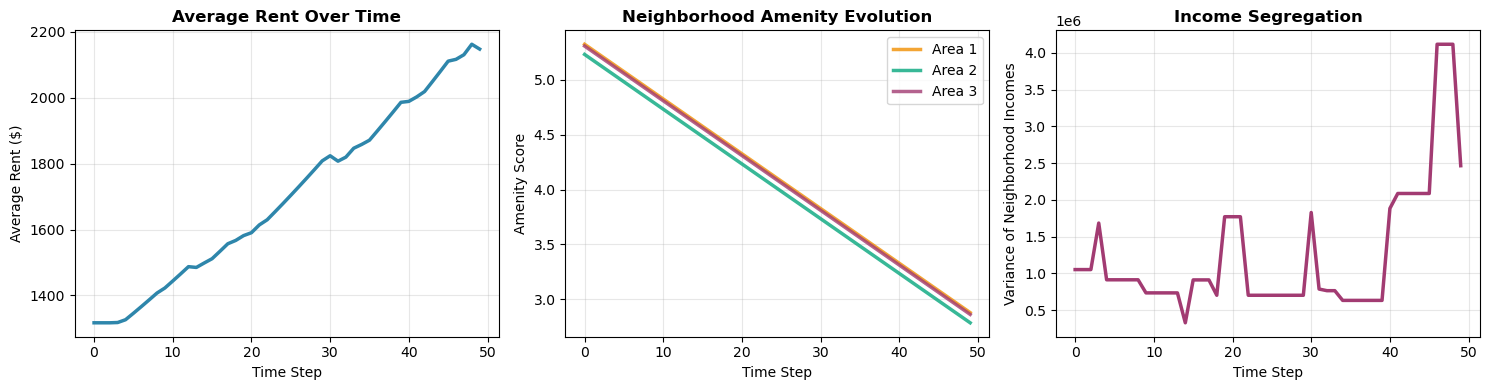


SIMULATION SUMMARY

Rent: $1317 → $2147
Change: +63.0%

Segregation: 1053068 → 2465158

Final Neighborhood Status:
  Area_1: Amenity=2.9, High-Income=8%
  Area_2: Amenity=2.8, High-Income=11%
  Area_3: Amenity=2.9, High-Income=21%

Vacancy Rate: 16.7%



In [209]:
sim.run()
sim.visualize()